In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import PIL
from PIL import Image
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

import re
from typing import List

Problem prilikom koriscenja Google Colab-a sa verzijom Pillow biblioteke. Za projekat se koristi verzija koja je manja od `10.0.0`

In [2]:
if PIL.__version__ == '10.0.0':
    !pip3 install Pillow==9.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 10.0.0
    Uninstalling Pillow-10.0.0:
      Successfully uninstalled Pillow-10.0.0


In [2]:
print(PIL.__version__)

9.5.0


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Ucitavanje podataka
-  Podaci se nalaze u direktorijumu `dataset`  
-  Iako su na prvi pogled podaci podeljeni na trening i test skup, test skup ne sadrzi izlaznu promenljivu i na njemu ne mozemo testirati koliko dobro nas model radi pa je potrebno podeliti `train.csv` na trening i test skup. Ali ce to biti odradjeno tek nakon pretprocesiranja teksta
<!-- -  Podaci su vec podeljeni na train i test skup tako da nema potrebe koristiti neku od ugradjenih funkcija (npr. `train_test_split` iz `sklearn.model_selection` paketa)   -->

In [4]:
data = pd.read_csv('dataset/train.csv')

In [5]:
(num_instances, num_attrs) = data.shape

print(f'Broj instanci: {num_instances:,}')
print(f'Broj atributa: {num_attrs} ({", ".join(data.columns.values)})')

Broj instanci: 31,962
Broj atributa: 3 (id, label, tweet)


In [6]:
data['label'].unique()

array([0, 1])

Kako imamo 2 moguce vrednosti izlaznog atributa (tweet sadrzi govor mrznje odnosno tweet ne sadrzi govor mrznje), rec je o binarnoj klasifikaciji. Naravno ulazni atribut predstavlja `tweet`

## Obrada train podataka

In [7]:
pd.set_option('display.max_colwidth', 1000)

data.head(n=10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


Kako je atributan `id` irelevantan mozemo ga izbaciti iz DataFrame-a

In [8]:
data.drop(['id'], axis=1, inplace=True)

data.head(n=10)

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,0,@user @user welcome here ! i'm it's so #gr8 !


### Obrada null vrednosti (nedostajucih vrednosti)

In [9]:
null_values = data.isna().any().any()

print('Nema null vrednosti') if not null_values else print(data.isna().sum())

Nema null vrednosti


Iako nema `NaN` vrednost to ne znaci da nas skup podataka zaista nema nedostajucih vrednosti, u nasem slucaju prazan tekst odnosno prazan tweet je takodje nedostajuca vrednost (iako je nemoguce objaviti prazan tweet). Nakon obrade teksta je moguce dobiti prazan tweet u slucaju da je sadrzaj tweet-a neka od Stopwords, emoji i sl. o cemu ce biti rec u nastavku

In [10]:
print(len(data.loc[data['tweet'] == '']))

0


#### Neke od metoda za obradjivanje null vrednosti
Kako nas skup ne sadrzi null vrednosti nema potrebe za daljom analizom nedostajucih podataka  
U slucaju da su postojale null vrednosti one su mogle biti obradjene na neki od sledecih nacina:  
-  **`Izbacivanjem`** (*train_data.dropna()*, pri cemu moramo voditi racuna da ne izbacimo previse podataka)  

-  **`Popunjavanjem default vrednostima`** (*train_data.fillna(def)*, ovde se postavlja pitanje sta izabrati kao default vrednost, u slucaju da nemamo vrednost za *label* atribut ako izaberemo 0 tweet-ovi koji sadrze govor mrznje mogu biti okarakaterisani kao tweet-ovi koji ne sadrze govor mrznje, slicno za 1)  

- **`Popunjavanje unapred / unazad`** (*train_data['label'].ffill()*, odnosno *train_data['label'].bfill()*)
    -  *ffill()* popunjava null vrednost na osnovu vrednosti koja se nalazi iznad nje
    -  *bfill()* popunjava null vrednost na osnovu vrednosti koja se nalazi ispod nje
- **...**

Nakon popunjavanja nedostajucih vrednosti mozemo iskoristiti metod `hist()` kako bi proverili koliko smo zaista uticali na nas set podataka  

Provera da li nas skup sadrzi duplirane podatke

In [11]:
print(f'Ima {len(data.loc[data["tweet"].duplicated() == True])} duplikata') if data.duplicated().any() else print('Nema duplikata')

Ima 2432 duplikata


In [12]:
data = data.drop_duplicates(keep='first')
data.shape

(29530, 2)

Naredni korak predstavlja obrada tweet-ova na taj nacin da ne sadrze `stopwords` ('I', 'myself', 'your', 'like' ...), `znakove interpunkcije` (',', '!', '.' ...), `emojis` (':)', ';)', ...) i sl. sto ne moze znacajnije uticati na tekst.
Takodje bice izvrsena lematizacija koja reci svodi na njihov osnovni oblik (npr. [`improve`, `improving`, `improved`] i sl. ce se svesti na `improve`) (Pored lematizacije postoji i stemming pri cemu se uklanjaju poslednji karakteri koji vode ka pogresnom zakljucku i spelovanju)

In [13]:
stop_words = set(stopwords.words('english'))
stop_words.add('user')

lemma = WordNetLemmatizer()

In [14]:
def preprocessing_tweet(tweet: str) -> str:
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'[^a-zA-Z]', ' ', new_tweet)   # Zameni sve sto nije slovo sa ' '
    new_tweet = [word for word in new_tweet.split() if word not in stop_words]
    new_tweet = ' '.join([lemma.lemmatize(word) for word in new_tweet])

    return new_tweet

In [15]:
data['tweet_cleaned'] = data['tweet'].apply(preprocessing_tweet)

data.head(n=10)

,label,tweet,tweet_cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare big talking leave chaos pay dispute get allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exam think school exam hate imagine actorslife revolutionschool girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land allin cavs champion cleveland clevelandcavaliers
9,0,@user @user welcome here ! i'm it's so #gr8 !,welcome gr


Nakon obrade teksta moze se desiti da je `tweet_cleaned` prazna niska, u slucaju da se tweet sastoji samo od taga, stopwords i sl. Zato je potrebno utvrditi koliko takvih instanci postoji i na koji nacin ih obraditi

In [16]:
empty_tweets = data.loc[data['tweet_cleaned'] == '']
empty_tweets.shape

(37, 3)

Kako je broj instanci neuporedivo manji od ukupnog broja instanci skupa podataka za treniranje mozemo ih izbaciti

In [17]:
data = data.loc[data['tweet_cleaned'] != '']
data.shape

(29493, 3)

Dodajemo kolonu `length` koja ce nam biti potrebna za odredjivanje autlajera

In [18]:
data['length'] = data['tweet_cleaned'].str.len()
data.head()

,label,tweet,tweet_cleaned,length
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run,53
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked,76
2,0,bihday your majesty,bihday majesty,14
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur,27
4,0,factsguide: society now #motivation,factsguide society motivation,29


## Podela na ulaznu odnosno izlaznu promenljivu i podela na trening i test skup

Podela trening skupa na ulaznu (`X`) odnosno izlaznu promenljivu (`Y`). Na ulazu dobijamo tweet a na izlazu se dobija odgovor na pitanje da li tweet sadrzi govor mrznje

In [19]:
X = data.drop(['label'], axis=1)
Y = data['label']

In [20]:
X.head()

,tweet,tweet_cleaned,length
0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run,53
1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked,76
2,bihday your majesty,bihday majesty,14
3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur,27
4,factsguide: society now #motivation,factsguide society motivation,29


In [21]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

Sledi podela na Train i Test skup podataka

In [22]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)

In [23]:
print(f'Broj instanci trening skupa: {X_train.shape[0]}')
print(f'Broj instanci test skupa: {X_test.shape[0]}')

Broj instanci trening skupa: 20645
Broj instanci test skupa: 8848


### Autlajeri
U slucaju obrade teksta duzina samog teksta moze uticati na sam model. Naime ukoliko se u nekom duzem tekstu nadju neke reci koje nisu znacajne za kategorizaciju tweet-a one mogu uticati na preprilagodjavanje modela. Nakon ociscenih tweet-ova dodata je kolona sa duzinom svakog tweet-a. Zatim se odredjuje Box plot na osnovu koga mozemo videti koje instance predstavljaju autlajere nakon cega slediti izbacivanje datih autlajera. Treba napomenuti da se obrada outliera vrsi nakon podele na train i test skup podataka kako se test skup podataka ne bi kompromitovao

In [24]:
train_data = pd.concat([X_train, Y_train], axis=1)

train_data.head()

,tweet,tweet_cleaned,length,label
22001,@user can't wait @user ! your stage looks awesome!!! see you at 11pm #cmafest #drinkingwithdolly #flockon,wait stage look awesome see pm cmafest drinkingwithdolly flockon,64,0
18793,"bbc news - orlando gay nightclub shooting: 50 killed, suspect is omar mateen love is love. get over it. smh",bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh,84,0
14980,friends on netflix!! ð,friend netflix,14,0
10457,"@user it was in ceain areas yeah, you not seen the videos? seeing little kids cry didn't do it for me!",ceain area yeah seen video seeing little kid cry,48,0
29761,thnx @user and pilot nick for the amazing experience above #grandcanyon this afternoon,thnx pilot nick amazing experience grandcanyon afternoon,56,0


In [25]:
hatred_tweets = train_data.loc[data['label'] == 1]['tweet_cleaned']
hatred_tweets_len = hatred_tweets.str.len()
non_hatred_tweets = train_data.loc[data['label'] == 0]['tweet_cleaned']
non_hatred_tweets_len = non_hatred_tweets.str.len()

Text(0.5, 1.0, 'Non-Hatred tweets length')

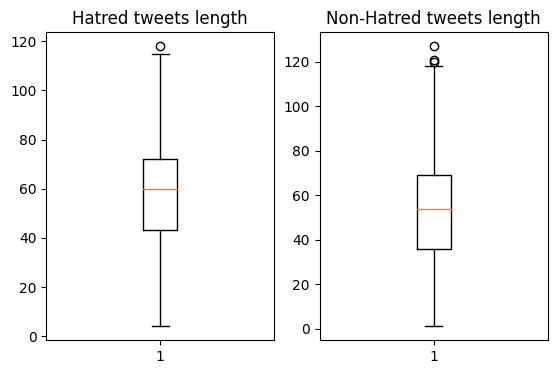

In [26]:
(hatred_Q1, hatred_Q3) = hatred_tweets_len.quantile([0.25, 0.75])
hatred_IQR = hatred_Q3 - hatred_Q1
hatred_min = hatred_Q1 - (1.5*hatred_IQR)
hatred_max = hatred_Q3 + (1.5*hatred_IQR)

(non_hatred_Q1, non_hatred_Q3) = non_hatred_tweets_len.quantile([0.25, 0.75])
non_hatred_IQR = non_hatred_Q3 - non_hatred_Q1
non_hatred_min = non_hatred_Q1 - (1.5*non_hatred_IQR)
non_hatred_max = non_hatred_Q3 + (1.5*non_hatred_IQR)

(fig, axes) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.clf()

plt.subplot(1, 3, 1)
plt.boxplot(hatred_tweets_len)
plt.title('Hatred tweets length')

plt.subplot(1, 3, 2)
plt.boxplot(non_hatred_tweets_len)
plt.title('Non-Hatred tweets length')

In [27]:
hatred_outliers = train_data.loc[
    (train_data['label'] == 1) &
    ((train_data['length'] > hatred_max) |
    (train_data['length'] < hatred_min))
]

print(f'Ukupno ima {hatred_outliers.shape[0]} tweet / tweet-ova sa govorom mrznje koji su autlajeri')
hatred_outliers.head()

Ukupno ima 1 tweet / tweet-ova sa govorom mrznje koji su autlajeri


,tweet,tweet_cleaned,length,label
2784,happy newyear! #sameshitnewyear #corruption #trump #terrorattack #fundamentalism #violence #isis #crisis #hatred #murder #terrorism,happy newyear sameshitnewyear corruption trump terrorattack fundamentalism violence isi crisis hatred murder terrorism,118,1


In [28]:
non_hatred_outliers = train_data.loc[
    (train_data['label'] == 0) &
    ((train_data['length'] > non_hatred_max) |
    (train_data['length'] < non_hatred_min))
]

print(f'Ukupno ima {non_hatred_outliers.shape[0]} tweet /  tweet-ova bez govora mrznje koji su autlajeri')
non_hatred_outliers.head()

Ukupno ima 3 tweet /  tweet-ova bez govora mrznje koji su autlajeri


,tweet,tweet_cleaned,length,label
26600,"auba wil go 2 city, vardy x liverpool morata wil stay @ juve n gud old giroud wil stil sta for arsenal next season #pathetic #wenger",auba wil go city vardy x liverpool morata wil stay juve n gud old giroud wil stil sta arsenal next season pathetic wenger,121,0
18958,epic video: blm zombie vs. trump kids youcanalwaystelldemocraticvoterstheyrloud&amp;neverhavecorrectfactsthisolderblackmanispitiful.,epic video blm zombie v trump kid youcanalwaystelldemocraticvoterstheyrloud amp neverhavecorrectfactsthisolderblackmanispitiful,127,0
5846,controversy trifecta: isis inspired mass shooting perpetrated with a legally purchased assault weapon aimed at gay victims. #loveislove,controversy trifecta isi inspired mass shooting perpetrated legally purchased assault weapon aimed gay victim loveislove,120,0


In [29]:
train_data.drop(hatred_outliers.index, inplace=True)
train_data.drop(non_hatred_outliers.index, inplace=True)
train_data.shape

(20641, 4)

In [30]:
train_data.head()

,tweet,tweet_cleaned,length,label
22001,@user can't wait @user ! your stage looks awesome!!! see you at 11pm #cmafest #drinkingwithdolly #flockon,wait stage look awesome see pm cmafest drinkingwithdolly flockon,64,0
18793,"bbc news - orlando gay nightclub shooting: 50 killed, suspect is omar mateen love is love. get over it. smh",bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh,84,0
14980,friends on netflix!! ð,friend netflix,14,0
10457,"@user it was in ceain areas yeah, you not seen the videos? seeing little kids cry didn't do it for me!",ceain area yeah seen video seeing little kid cry,48,0
29761,thnx @user and pilot nick for the amazing experience above #grandcanyon this afternoon,thnx pilot nick amazing experience grandcanyon afternoon,56,0


## Vizuelni prikaz train podataka

In [31]:
X_train = X_train['tweet_cleaned']
X_test = X_test['tweet_cleaned']

X_train.head()

22001                        wait stage look awesome see pm cmafest drinkingwithdolly flockon
18793    bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh
14980                                                                          friend netflix
10457                                        ceain area yeah seen video seeing little kid cry
29761                                thnx pilot nick amazing experience grandcanyon afternoon
Name: tweet_cleaned, dtype: object

In [32]:
train_data.head()

,tweet,tweet_cleaned,length,label
22001,@user can't wait @user ! your stage looks awesome!!! see you at 11pm #cmafest #drinkingwithdolly #flockon,wait stage look awesome see pm cmafest drinkingwithdolly flockon,64,0
18793,"bbc news - orlando gay nightclub shooting: 50 killed, suspect is omar mateen love is love. get over it. smh",bbc news orlando gay nightclub shooting killed suspect omar mateen love love get smh,84,0
14980,friends on netflix!! ð,friend netflix,14,0
10457,"@user it was in ceain areas yeah, you not seen the videos? seeing little kids cry didn't do it for me!",ceain area yeah seen video seeing little kid cry,48,0
29761,thnx @user and pilot nick for the amazing experience above #grandcanyon this afternoon,thnx pilot nick amazing experience grandcanyon afternoon,56,0


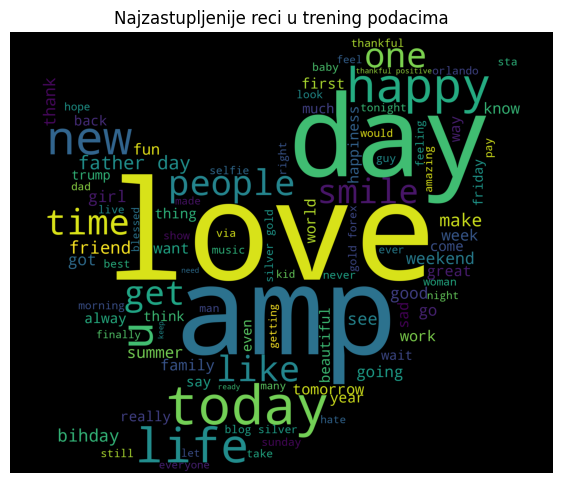

In [33]:
all_tweets_img = np.array(Image.open('images/all_tweets.png'))

all_tweets = ' '.join(X_train.tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=all_tweets_img,
).generate(all_tweets)

plt.title('Najzastupljenije reci u trening podacima')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

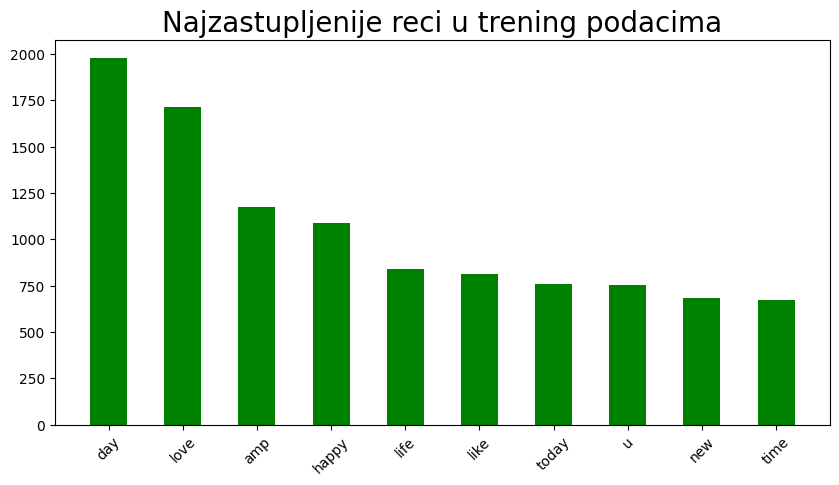

In [34]:
all_words = FreqDist(
    ' '.join(X_train).split()
).most_common(10)

all_words_data = pd.DataFrame(all_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    all_words_data['words'].tolist(),
    all_words_data['frequency'].tolist(),
    width=0.5,
    color='green'
)

plt.title('Najzastupljenije reci u trening podacima', fontsize=20)
plt.xticks(rotation=45)
plt.show()

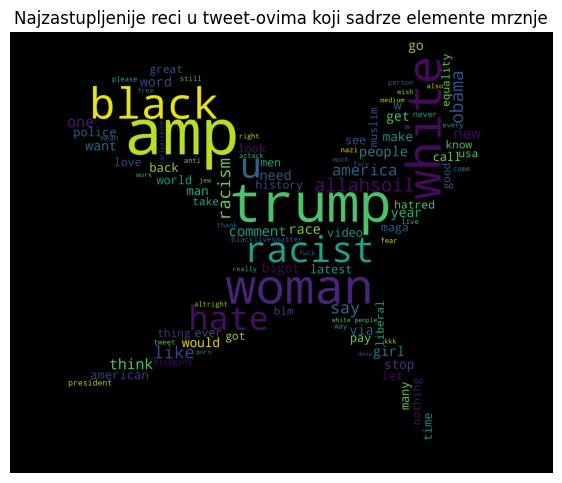

In [35]:
hatred_tweets_img = np.array(Image.open('images/hatred_tweets.png'))
hatred_tweets_data = train_data.loc[train_data['label'] == 1]

hatred_tweets = ' '.join(hatred_tweets_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=hatred_tweets_img,
).generate(hatred_tweets)

plt.title('Najzastupljenije reci u tweet-ovima koji sadrze elemente mrznje')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

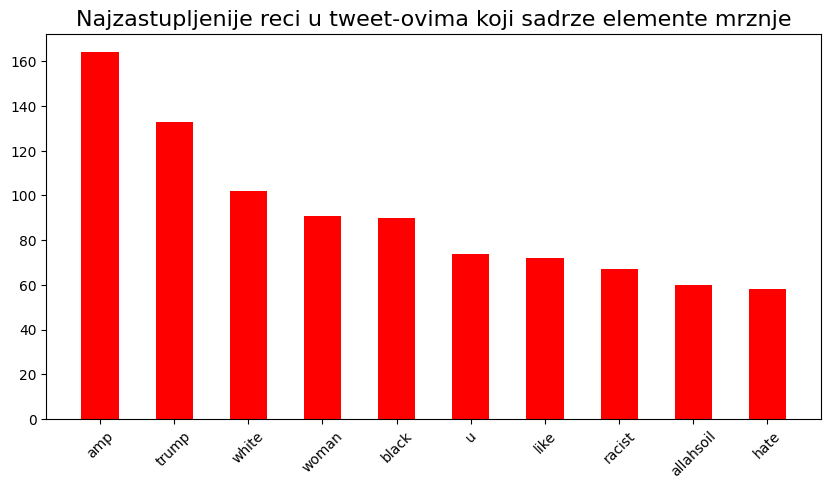

In [36]:
hatred_words = FreqDist(
    ' '.join(train_data.loc[train_data['label'] == 1]['tweet_cleaned']).split()
).most_common(10)

hatred_df = pd.DataFrame(hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    hatred_df['words'].tolist(),
    hatred_df['frequency'].tolist(),
    width=0.5,
    color='red'
)

plt.title('Najzastupljenije reci u tweet-ovima koji sadrze elemente mrznje', fontsize=16)
plt.xticks(rotation=45)
plt.show()

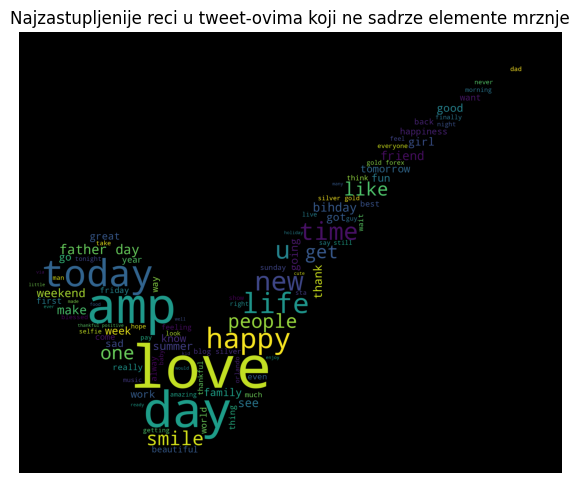

In [37]:
non_hatred_tweets_img = np.array(Image.open('images/non-hatred_tweets.png'))
non_hatred_tweets_data = train_data.loc[train_data['label'] == 0]

non_hatred_tweets = ' '.join(non_hatred_tweets_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=non_hatred_tweets_img,
).generate(non_hatred_tweets)

plt.title('Najzastupljenije reci u tweet-ovima koji ne sadrze elemente mrznje')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

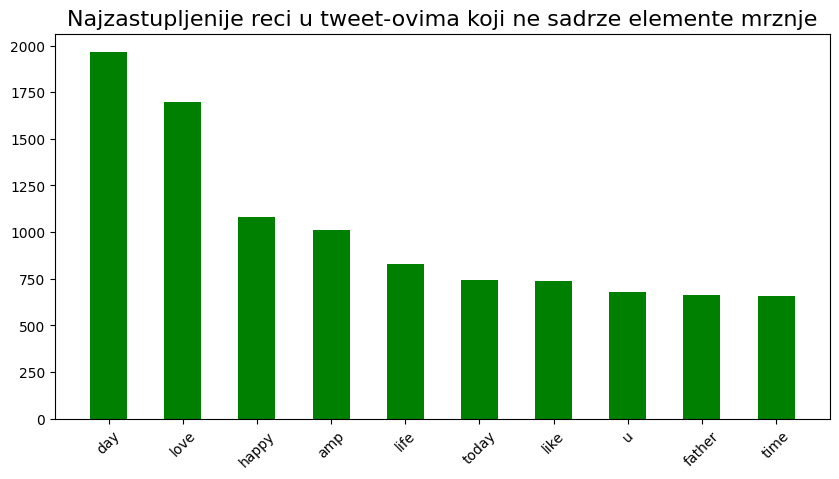

In [38]:
non_hatred_words = FreqDist(
    ' '.join(train_data.loc[train_data['label'] == 0]['tweet_cleaned']).split()
).most_common(10)

non_hatred_df = pd.DataFrame(non_hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    non_hatred_df['words'].tolist(),
    non_hatred_df['frequency'].tolist(),
    width=0.5,
    color='green'
)

plt.title('Najzastupljenije reci u tweet-ovima koji ne sadrze elemente mrznje', fontsize=16)
plt.xticks(rotation=45)
plt.show()

### Hatred vs Non-Hatred klase

In [39]:
(non_hatred, hatred) = train_data['label'].value_counts()
hatred_perc = hatred / (train_data.shape[0]) * 100
non_hatred_perc = non_hatred / (train_data.shape[0]) * 100

print(colored(
    'Broj instanci odnosno broj tweet-ova koji su okaraksterisani kao govor mrznje: '\
    f'{hatred:,} ({hatred_perc:.2f}%)',
    'red')
)
print(colored(
    'Broj instanci odnosno broj tweet-ova koji nisu okarakterisani kao govor mrznje: '\
    f'{non_hatred:,} ({non_hatred_perc:.2f}%)',
    'green')
)

Broj instanci odnosno broj tweet-ova koji su okaraksterisani kao govor mrznje: 1,405 (6.81%)
Broj instanci odnosno broj tweet-ova koji nisu okarakterisani kao govor mrznje: 19,236 (93.19%)


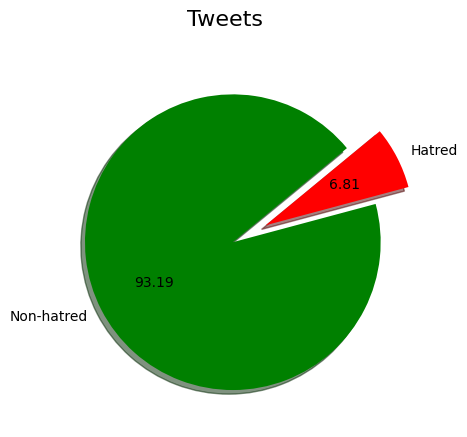

In [40]:
labels = 'Hatred', 'Non-hatred'

fig, ax = plt.subplots()
fig.suptitle(t='Tweets', fontsize=16)

ax.pie(
    x=[hatred, non_hatred],
    explode=(0.25, 0),
    labels=labels,
    colors=['Red', 'Green'],
    autopct='%.2f',
    shadow=True,
    startangle=15
);

Iz prilozenog se moze videti da imamo problem sa nebalansiranim klasama gde su tweet-ovi koji su okarakterisani kao tweet-ovi koji ne sadrze govor mrznje zastupljeniji u nasem trening skupu (odnos 93.19% / 6.81%). Problem moze biti da se nas model preprilagodi podacima i da daje jako dobar accuracy ali da na nepoznatim podacima daje lose rezultate

# Problem sa nebalansiranim klasama

Kako nas trening skup sadrzi nebalansirane klase (odnos 93% - 7% u korist tweet-ova koji ne sadrze govor mrznje) moramo primeniti neku od tehnika rada sa nebalansiranim klasama.  
- Oversampling (Prilagodjavanje manjeg skupa vecem)
    - RandomOverSampler
    - SMOTE
- Undersampling (Prilagodjavanje veceg skupa manjem)
    - RandomUnderSampling
    - NearMiss
    - CondenseNearestNeighbour
- Combination Oversampling & Undersampling (Kombinacija prethodna dva)
    - SMOTEENN
- Imbalanced Ensemble
    - BalancedRandomForestClassifier

Pre primene nekih od modela za rad sa podacima potrebno je izvrsiti transformaciju nasih podataka iz tekstualne u numericku kategoriju koristecu `TfidVectorizer` klasu.  
`TF-IDF` (`T`erm `F`requency - `I`nverse `D`ocument `F`requency) matrica koristi frekvenciju pojavljivanja reci da bi odredila koliko je data rec relevantna u datom dokumentu

In [41]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer.fit(X_train)

X_train_tf_idf = tf_idf_vectorizer.transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

X_train_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Standardni model koji bi koristili da nemamo problem sa nebalansiranima klasama. (Stabla odlucivanja)

In [42]:
model_dtc = DecisionTreeClassifier(max_depth=6, min_samples_split=50, criterion='gini')

model_dtc.fit(X_train_tf_idf, Y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=50)

In [43]:
print(f'{model_dtc.score(X_test_tf_idf, Y_test)}')

0.9415687160940326


Accuracy naseg modela je 0.94, medjutim to nije prava slika modela s obzirom da nase klase nisu balansirane.  
Accuracy se racuna po formuli: $ \frac{TN + TP}{TP + FP + TN + FN} $, gde su parametri instance koje:  
-  TN (True Negative) - Model predvidja da su negativne i one su negativne
-  TP (True Positive) - Model predvidja da su pozitivne i one su pozitivne
-  FN (False Negative) - Model predvidja da su negativne ali su one pozitivne
-  FP (False Positive) - Model predvidja da su positivne ali su one negativne  

Iz date formule se moze primetiti da losi rezultati u manjoj klasi ne uticu drasticno na konacan rezultat

In [44]:
Y_pred = model_dtc.predict(X_test_tf_idf)

CM = confusion_matrix(Y_test, Y_pred)

(TN, FN, TP, FP) = CM[0][0], CM[1][0], CM[1][1], CM[0][1]

print(f'True positive: {TP}')
print(f'False positive: {FP}')
print(f'True negative: {TN}')
print(f'False negative: {FN}')

print(f'Accuracy: {(TN + TP) / (TP + FP + TN + FN)}')

True positive: 116
False positive: 30
True negative: 8215
False negative: 487
Accuracy: 0.9415687160940326


Zato koristimo funkciju `classification_report_imbalanced` koja nam daje bolju sliku modela

In [45]:
print(classification_report_imbalanced(Y_test, Y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      1.00      0.19      0.97      0.44      0.21      8245
          1       0.79      0.19      1.00      0.31      0.44      0.18       603

avg / total       0.93      0.94      0.25      0.92      0.44      0.20      8848



U tabeli se moze videti da nebalansiranost klasa dolazi do izrazaja pa je sledeci korak obrada nebalansiranih klasa

SMOTE

In [46]:
imbalanced_model_smote = make_pipeline(TfidfVectorizer(), SMOTE(), MultinomialNB())

imbalanced_model_smote.fit(X_train, Y_train)

Y_pred_smote = imbalanced_model_smote.predict(X_test)

In [47]:
print(classification_report_imbalanced(Y_test, Y_pred_smote))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.91      0.85      0.95      0.88      0.78      8245
          1       0.41      0.85      0.91      0.56      0.88      0.77       603

avg / total       0.95      0.91      0.86      0.92      0.88      0.78      8848



RandomOverSampler

In [48]:
imbalanced_model_ros = make_pipeline(TfidfVectorizer(), RandomOverSampler(), MultinomialNB())

imbalanced_model_ros.fit(X_train, Y_train)

Y_pred_ros = imbalanced_model_ros.predict(X_test)

In [49]:
print(classification_report_imbalanced(Y_test, Y_pred_ros))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.91      0.85      0.95      0.88      0.78      8245
          1       0.40      0.85      0.91      0.55      0.88      0.77       603

avg / total       0.95      0.90      0.85      0.92      0.88      0.78      8848



Kako RandomOverSampler i SMOTE daju jako slicne rezultate koristicemo RandomOverSampler (laksi rad sa tekstualnim podacima)

In [50]:
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')

(X_resampled_ros, Y_resampled_ros) = ros.fit_resample(np.array(X_train).reshape(-1, 1), Y_train)

In [51]:
X_resampled_ros_df = pd.DataFrame(X_resampled_ros)